In [ ]:
# Install required libraries (run once)
!pip install pandas panel hvplot plotly seaborn matplotlib scikit-learn prophet statsmodels tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import panel as pn
import hvplot.pandas
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Forecasting and Modeling
from prophet import Prophet
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

pn.extension('plotly')


In [ ]:
# Load CSV
df = pd.read_csv("minhist.csv")

# Reshape Data
df_long = df.melt(id_vars="State_or_Jurisdiction", var_name="Year", value_name="Wage")
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
df_long["Wage"] = pd.to_numeric(df_long["Wage"], errors="coerce")
df_long.dropna(subset=["Wage"], inplace=True)

# Quick look
df_long.head()


,State_or_Jurisdiction,Year,Wage
0,Federal_FLSA,1968,1.60
2,Alaska,1968,2.10
7,Connecticut,1968,1.40
8,Delaware,1968,1.25
11,Hawaii,1968,1.25


In [ ]:
# CPI All Items U.S. City Average (monthly, not seasonally adjusted)
import pandas_datareader.data as web
from datetime import datetime

start = datetime(2000, 1, 1)
end = datetime(2025, 1, 1)

cpi = web.DataReader('CPIAUCNS', 'fred', start, end).reset_index()
cpi['Year'] = cpi['DATE'].dt.year
cpi = cpi.groupby('Year')['CPIAUCNS'].mean().reset_index()
cpi.rename(columns={"CPIAUCNS": "CPI_Avg"}, inplace=True)

# Quick look
cpi.head()


,Year,CPI_Avg
0,2000,172.200000
1,2001,177.066667
2,2002,179.875000
3,2003,183.958333
4,2004,188.883333


In [ ]:
# Merge minimum wage and CPI
merged = df_long.merge(cpi, how='left', on='Year')
merged['Real_Wage'] = merged['Wage'] / (merged['CPI_Avg'] / merged.loc[merged['Year']==2024, 'CPI_Avg'].values[0])

# Fill any gaps carefully
merged.dropna(subset=["Real_Wage"], inplace=True)

# Look
merged.head()


,State_or_Jurisdiction,Year,Wage,CPI_Avg,Real_Wage
610,Federal_FLSA,2000,5.15,172.2,9.381519
611,Alaska,2000,5.65,172.2,10.292346
612,Arkansas,2000,5.15,172.2,9.381519
613,California,2000,5.75,172.2,10.474511
614,Colorado,2000,5.15,172.2,9.381519


In [ ]:
# Growth Rate
merged['Wage_Growth'] = merged.groupby('State_or_Jurisdiction')['Wage'].pct_change() * 100

# Inflation-adjusted growth
merged['Real_Wage_Growth'] = merged.groupby('State_or_Jurisdiction')['Real_Wage'].pct_change() * 100

# Rolling Average (3-year)
merged['Wage_Rolling_Avg'] = merged.groupby('State_or_Jurisdiction')['Wage'].rolling(3).mean().reset_index(0,drop=True)

# Delta from Federal Minimum
fed = merged[merged['State_or_Jurisdiction'] == "Federal_FLSA"][['Year', 'Wage']]
fed.columns = ['Year', 'Federal_Wage']
merged = merged.merge(fed, on='Year', how='left')
merged['Delta_from_Federal'] = merged['Wage'] - merged['Federal_Wage']


In [ ]:
fig = px.line(
    merged[merged['State_or_Jurisdiction'].isin(["California", "Texas", "Florida", "New York"])],
    x="Year", y="Wage", color="State_or_Jurisdiction",
    title="State Minimum Wage Trends (2000–2025)"
)
fig.show()


In [ ]:
fig = px.line(
    merged[merged['State_or_Jurisdiction'].isin(["California", "Texas", "Florida", "New York"])],
    x="Year", y="Real_Wage", color="State_or_Jurisdiction",
    title="Real Minimum Wages Adjusted for Inflation"
)
fig.show()


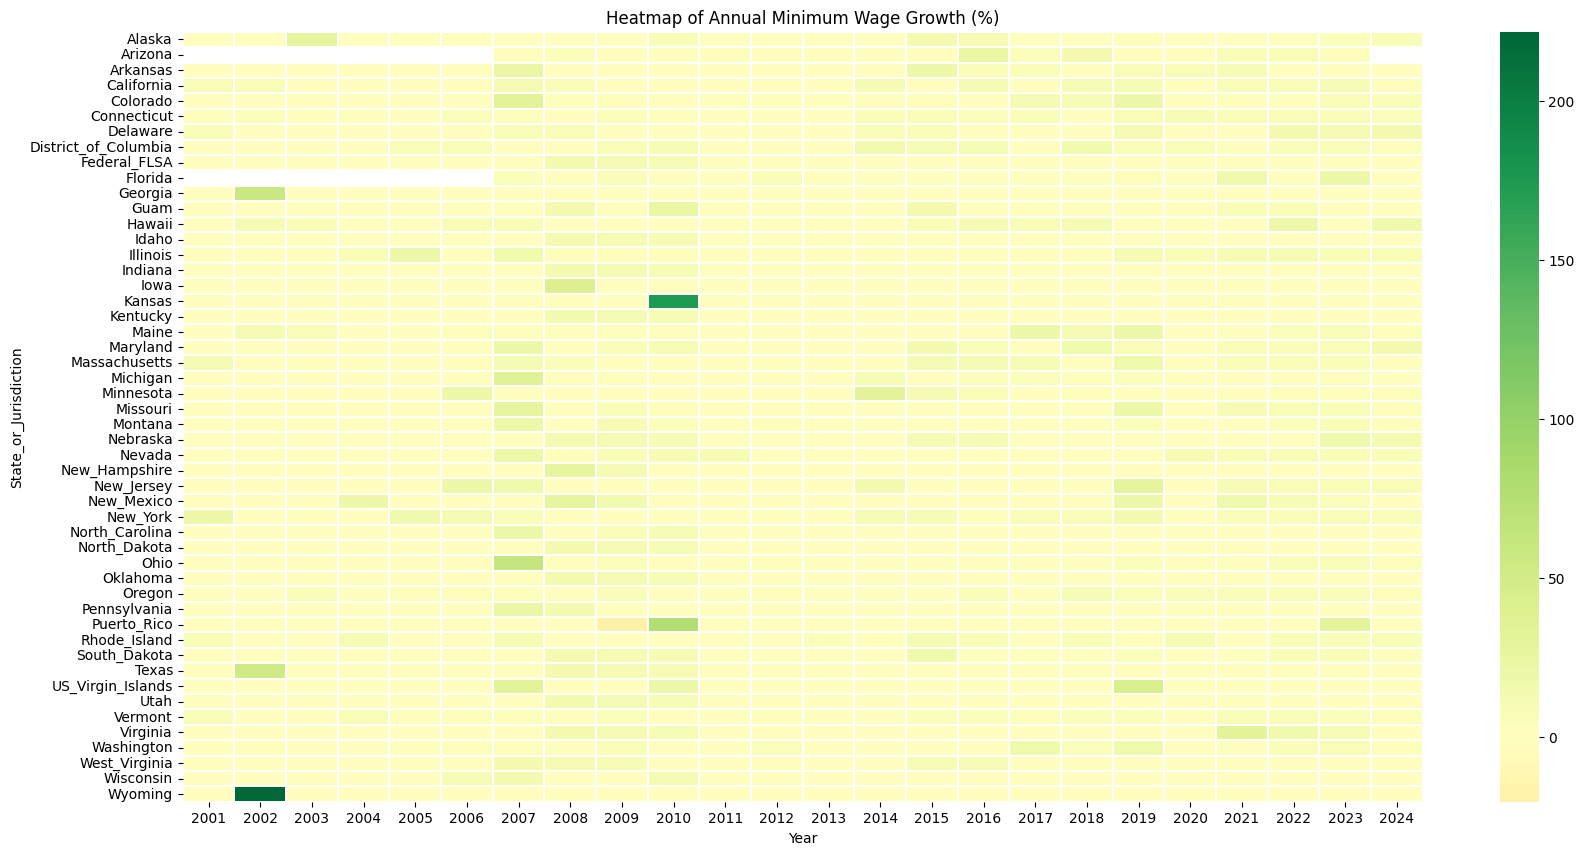

In [ ]:
growth_pivot = merged.pivot_table(values='Wage_Growth', index='State_or_Jurisdiction', columns='Year')

plt.figure(figsize=(20, 10))
sns.heatmap(growth_pivot, cmap="RdYlGn", center=0, annot=False, linewidths=0.1)
plt.title('Heatmap of Annual Minimum Wage Growth (%)')
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmp6yqll_/zn3o8ei6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmp6yqll_/_hisfd_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68801', 'data', 'file=/tmp/tmpmp6yqll_/zn3o8ei6.json', 'init=/tmp/tmpmp6yqll_/_hisfd_a.json', 'output', 'file=/tmp/tmpmp6yqll_/prophet_modelulo2rrhx/prophet_model-20250427235532.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:55:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:

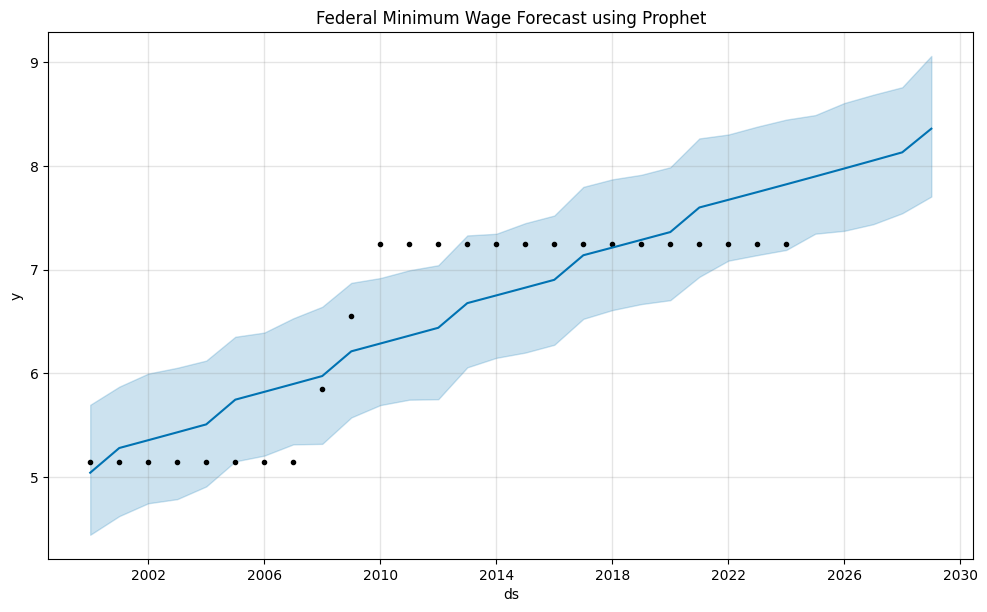

In [ ]:
# Prophet Modeling
fed_data = merged[merged['State_or_Jurisdiction']=='Federal_FLSA'][['Year','Wage']]
fed_data = fed_data.rename(columns={"Year":"ds", "Wage":"y"})

# Prophet expects 'ds' to be datetime
fed_data['ds'] = pd.to_datetime(fed_data['ds'], format='%Y')

m = Prophet()
m.fit(fed_data)

future = m.make_future_dataframe(periods=5, freq='Y')
forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.title('Federal Minimum Wage Forecast using Prophet')
plt.show()


In [ ]:
# Predicting Federal Wage

rf_data = merged[merged['State_or_Jurisdiction']=="Federal_FLSA"][['Year', 'Wage']]
X = rf_data[['Year']]
y = rf_data['Wage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Predict next 5 years
future_years = pd.DataFrame({'Year': list(range(2025, 2031))})
predictions = rf.predict(future_years)

# View
future_years['Predicted_Wage'] = predictions
print(future_years)


   Year  Predicted_Wage
0  2025            7.25
1  2026            7.25
2  2027            7.25
3  2028            7.25
4  2029            7.25
5  2030            7.25


In [ ]:
# Widgets
state_widget = pn.widgets.MultiSelect(name="States", options=sorted(merged['State_or_Jurisdiction'].unique()), value=["California", "New York"], size=8)
year_slider = pn.widgets.IntRangeSlider(name="Year Range", start=2000, end=2025, value=(2000, 2025))
chart_choice = pn.widgets.RadioButtonGroup(name="Chart Type", options=["Wage", "Real Wage", "Growth Rate"])

@pn.depends(state_widget, year_slider, chart_choice)
def interactive_plot(states, year_range, chart_type):
    df_filtered = merged[
        (merged['State_or_Jurisdiction'].isin(states)) &
        (merged['Year'].between(year_range[0], year_range[1]))
    ]

    if chart_type == "Wage":
        return df_filtered.hvplot.line(x="Year", y="Wage", by="State_or_Jurisdiction", title="Nominal Minimum Wage Trends", width=800, height=500)
    elif chart_type == "Real Wage":
        return df_filtered.hvplot.line(x="Year", y="Real_Wage", by="State_or_Jurisdiction", title="Inflation Adjusted Minimum Wages", width=800, height=500)
    elif chart_type == "Growth Rate":
        return df_filtered.hvplot.line(x="Year", y="Wage_Growth", by="State_or_Jurisdiction", title="Wage Growth Rate", width=800, height=500)

dashboard = pn.Column(
    "# 💵 Interactive Minimum Wage Explorer",
    state_widget,
    year_slider,
    chart_choice,
    interactive_plot
)

dashboard.servable()


Column
    [0] Markdown(str)
    [1] MultiSelect(name='States', options=['Alaska', 'Arizona', ...], size=8, value=['California'])
    [2] IntRangeSlider(end=2025, name='Year Range', start=2000, value=(2000, 2025), value_end=2025, value_start=2000)
    [3] RadioButtonGroup(name='Chart Type', options=['Wage', 'Real Wage', ...], value='Wage')
    [4] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [ ]:
# 🛠 Install required packages (if not already installed)
!pip install pandas pandas_datareader matplotlib plotly panel hvplot tensorflow

# 🔎 Import libraries for data handling and visualization
import pandas as pd
import numpy as np
import datetime

# Data retrieval utilities
from pandas_datareader import data as pdr

# Plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Panel for interactive dashboard
import panel as pn
import hvplot.pandas  # adds hvplot method to pandas DataFrame
pn.extension('bokeh')  # enable Panel with Bokeh backend

# Suppress TensorFlow warnings for clarity (for the ML section)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [ ]:
# 📥 Fetch CPI-U (Consumer Price Index for All Urban Consumers, All Items) from FRED
# Source: U.S. Bureau of Labor Statistics via FRED (series CPIAUCSL)&#8203;:contentReference[oaicite:7]{index=7}
cpi = pdr.DataReader('CPIAUCSL', 'fred', start='1960-01-01')  # monthly CPI index (1982-84=100)
cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)

# Calculate year-over-year inflation rate from CPI index
cpi['Inflation_YoY'] = cpi['CPI'].pct_change(periods=12) * 100  # % change from 12 months ago
cpi.head(3)


,CPI,Inflation_YoY
DATE,,
1960-01-01,29.37,NaN
1960-02-01,29.41,NaN
1960-03-01,29.41,NaN


In [ ]:
# 📥 Fetch Unemployment Rate (UNRATE) from FRED
# Source: U.S. Bureau of Labor Statistics via FRED (series UNRATE)&#8203;:contentReference[oaicite:8]{index=8}
unemp = pdr.DataReader('UNRATE', 'fred', start='1960-01-01')  # monthly unemployment rate (%)
unemp.rename(columns={'UNRATE': 'UnemploymentRate'}, inplace=True)
unemp.head(3)

,UnemploymentRate
DATE,
1960-01-01,5.2
1960-02-01,4.8
1960-03-01,5.4


In [ ]:
# 📥 Fetch Real GDP (GDPC1) from FRED
# Source: U.S. Bureau of Economic Analysis via FRED (series GDPC1)&#8203;:contentReference[oaicite:9]{index=9}
gdp = pdr.DataReader('GDPC1', 'fred', start='1960-01-01')  # quarterly real GDP, billions of chained 2012 dollars
gdp.rename(columns={'GDPC1': 'RealGDP'}, inplace=True)
# Calculate year-over-year GDP growth %
gdp['GDP_YoY'] = gdp['RealGDP'].pct_change(periods=4) * 100  # % change from 4 quarters ago
gdp.tail(3)


,RealGDP,GDP_YoY
DATE,,
2024-04-01,23223.906,3.036849
2024-07-01,23400.294,2.718769
2024-10-01,23542.349,2.533684


In [ ]:
# 📥 Fetch Average Hourly Earnings (AHETPI) from FRED
# Source: U.S. Bureau of Labor Statistics via FRED (series AHETPI)&#8203;:contentReference[oaicite:10]{index=10}
# AHETPI = Average Hourly Earnings of Production and Nonsupervisory Employees, Total Private, monthly, $ per hour
wages = pdr.DataReader('AHETPI', 'fred', start='1964-01-01')  # data starts in 1964
wages.rename(columns={'AHETPI': 'AvgHourlyEarnings'}, inplace=True)
# Align CPI to same index to calculate real earnings
wages = wages.join(cpi['CPI'], how='left')  # join CPI by date
# Calculate Real Average Hourly Earnings in constant 1982-84 dollars (nominal wage * 100/CPI index)
wages['RealAvgHourlyEarnings'] = wages['AvgHourlyEarnings'] * 100 / wages['CPI']
# Calculate YoY nominal wage growth and YoY real wage growth
wages['WageGrowth_YoY'] = wages['AvgHourlyEarnings'].pct_change(periods=12) * 100
wages['RealWageGrowth_YoY'] = wages['RealAvgHourlyEarnings'].pct_change(periods=12) * 100
wages.tail(3)


,AvgHourlyEarnings,CPI,RealAvgHourlyEarnings,WageGrowth_YoY,RealWageGrowth_YoY
DATE,,,,,
2025-01-01,30.80,319.086,9.652570,4.018913,0.989811
2025-02-01,30.91,319.775,9.666172,4.179306,1.327671
2025-03-01,30.96,319.615,9.686654,3.892617,1.452101


In [ ]:
# 📥 Fetch Median House Price and Median Household Income to assess housing affordability
# Source (House Price): U.S. Census Bureau & HUD via FRED (series MSPUS)&#8203;:contentReference[oaicite:11]{index=11}
# Source (Household Income): U.S. Census Bureau via FRED (series MEHOINUSA646N)&#8203;:contentReference[oaicite:12]{index=12}
house_price = pdr.DataReader('MSPUS', 'fred', start='1960-01-01')  # quarterly median sale price of houses sold ($)
income = pdr.DataReader('MEHOINUSA646N', 'fred', start='1984-01-01')  # annual median household income ($
house_price.rename(columns={'MSPUS': 'MedianHousePrice'}, inplace=True)
income.rename(columns={'MEHOINUSA646N': 'MedianHouseholdIncome'}, inplace=True)

# Convert house prices to annual by taking yearly average (to match income frequency)
annual_price = house_price.resample('A').mean()
annual_price.index = annual_price.index.year  # use year as index for convenience
income.index = income.index.year  # convert income index to year

# Combine into one DataFrame for affordability ratio
housing = pd.DataFrame({
    'MedianHousePrice': annual_price['MedianHousePrice'],
    'MedianHouseholdIncome': income['MedianHouseholdIncome']
})
housing['Price_Income_Ratio'] = housing['MedianHousePrice'] / housing['MedianHouseholdIncome']
housing.dropna(inplace=True)
housing.tail(3)


,MedianHousePrice,MedianHouseholdIncome,Price_Income_Ratio
DATE,,,
2021,383000.0,70780.0,5.411133
2022,432950.0,74580.0,5.805176
2023,426525.0,80610.0,5.291217


In [ ]:
# 📥 Fetch Crude Oil Prices (WTI) from FRED for context on energy (monthly average price)
# Source: U.S. Energy Information Administration via FRED (series DCOILWTICO)&#8203;:contentReference[oaicite:13]{index=13}
oil = pdr.DataReader('DCOILWTICO', 'fred', start='1970-01-01')  # daily WTI price
# Convert to monthly average price
oil_monthly = oil['DCOILWTICO'].resample('M').mean()
oil_monthly.name = 'WTI_Price'
# Note: Data for WTI starts in 1986; earlier 1970s oil price will be annotated from historical context.
oil_monthly.head(3)


,WTI_Price
DATE,
1986-01-31,22.925455
1986-02-28,15.454737
1986-03-31,12.612500


In [ ]:
# 📝 Check data coverage and basic stats
print("CPI data range:", cpi.index.min().date(), "to", cpi.index.max().date(),
      "| Last CPI index value:", round(cpi['CPI'].iloc[-1], 1))
print("Unemployment data range:", unemp.index.min().date(), "to", unemp.index.max().date(),
      "| Latest unemployment rate:", unemp['UnemploymentRate'].iloc[-1], "%")
print("Wage data range:", wages.index.min().date(), "to", wages.index.max().date(),
      "| Last nominal avg hourly earnings: $", round(wages['AvgHourlyEarnings'].iloc[-1],2))
print("Income data range:", int(income.index.min()), "to", int(income.index.max()),
      "| Last median household income: $", int(income['MedianHouseholdIncome'].iloc[-1]))
print("House price data range:", house_price.index.min().date(), "to", house_price.index.max().date(),
      "| Last median house price: $", int(house_price['MedianHousePrice'].iloc[-1]))


CPI data range: 1960-01-01 to 2025-03-01 | Last CPI index value: 319.6
Unemployment data range: 1960-01-01 to 2025-03-01 | Latest unemployment rate: 4.2 %
Wage data range: 1964-01-01 to 2025-03-01 | Last nominal avg hourly earnings: $ 30.96
Income data range: 1984 to 2023 | Last median household income: $ 80610
House price data range: 1963-01-01 to 2025-01-01 | Last median house price: $ 416900


In [ ]:
# 📊 Key stats for specific periods
# Define periods of interest
stagflation_period = (1973, 1982)   # covering the 1973 oil shock through early 1980s
great_recession_period = (2007, 2012)
pandemic_period = (2020, 2025)

# Inflation peaks
peak_infl_70s = cpi.loc[f'{stagflation_period[0]}':f'{stagflation_period[1]}', 'Inflation_YoY'].max()
peak_infl_2008 = cpi.loc['2007':'2012', 'Inflation_YoY'].max()
peak_infl_2020s = cpi.loc['2020':'2025', 'Inflation_YoY'].max()

# Unemployment peaks
peak_unemp_70s = unemp.loc[f'{stagflation_period[0]}':f'{stagflation_period[1]}', 'UnemploymentRate'].max()
peak_unemp_2008 = unemp.loc['2007':'2012', 'UnemploymentRate'].max()
peak_unemp_2020s = unemp.loc['2020':'2025', 'UnemploymentRate'].max()

# Real wage change over 1973-1982 (to see stagnation)
real_wage_1973 = wages.loc['1973-01-01', 'RealAvgHourlyEarnings']
real_wage_1982 = wages.loc['1982-01-01', 'RealAvgHourlyEarnings']
real_wage_change_70s = (real_wage_1982 - real_wage_1973) / real_wage_1973 * 100

print(f"Peak Inflation in 1970s period: {peak_infl_70s:.1f}%")
print(f"Peak Inflation in 2007-2012: {peak_infl_2008:.1f}%")
print(f"Peak Inflation in 2020s: {peak_infl_2020s:.1f}%\n")

print(f"Peak Unemployment in 1970s period: {peak_unemp_70s:.1f}%")
print(f"Peak Unemployment in 2007-2012: {peak_unemp_2008:.1f}%")
print(f"Peak Unemployment in 2020s: {peak_unemp_2020s:.1f}%\n")

print(f"Real avg hourly earnings change 1973-1982: {real_wage_change_70s:.1f}%")


Peak Inflation in 1970s period: 14.6%
Peak Inflation in 2007-2012: 5.5%
Peak Inflation in 2020s: 9.0%

Peak Unemployment in 1970s period: 10.8%
Peak Unemployment in 2007-2012: 10.0%
Peak Unemployment in 2020s: 14.8%

Real avg hourly earnings change 1973-1982: -13.4%


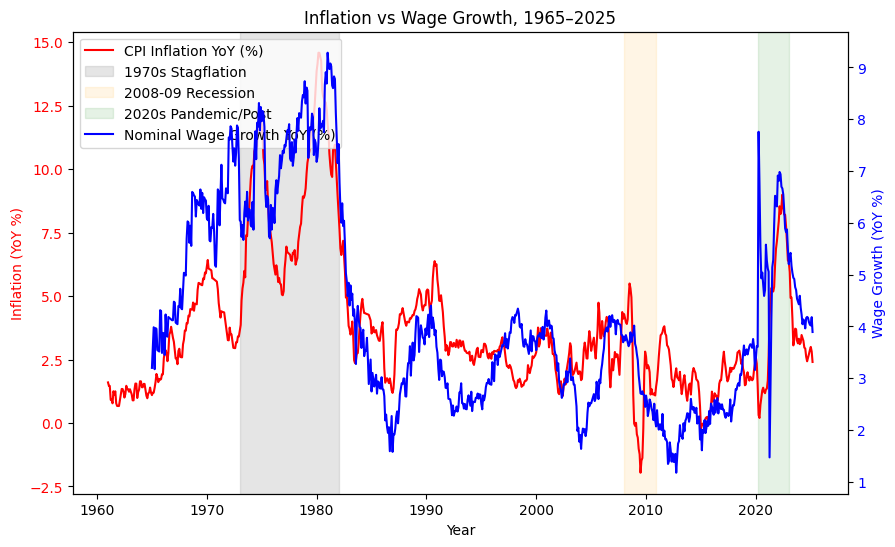

In [ ]:
# 📈 Plot Inflation vs Wage Growth over the long run
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(cpi.index, cpi['Inflation_YoY'], color='red', label='CPI Inflation YoY (%)')
ax1.set_ylabel('Inflation (YoY %)', color='red')
ax1.set_xlabel('Year')
ax1.tick_params(axis='y', labelcolor='red')
# Secondary axis for wage growth
ax2 = ax1.twinx()
ax2.plot(wages.index, wages['WageGrowth_YoY'], color='blue', label='Nominal Wage Growth YoY (%)')
ax2.set_ylabel('Wage Growth (YoY %)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
# Mark the key periods roughly
ax1.axvspan('1973-01', '1982-01', color='gray', alpha=0.2, label='1970s Stagflation')
ax1.axvspan('2008-01', '2010-12', color='orange', alpha=0.1, label='2008-09 Recession')
ax1.axvspan('2020-03', '2023-01', color='green', alpha=0.1, label='2020s Pandemic/Post')
# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc='upper left')
ax1.set_title('Inflation vs Wage Growth, 1965–2025')
plt.show()


In [ ]:
# 😖 Compute Misery Index = Inflation + Unemployment
misery = pd.DataFrame({
    'MiseryIndex': cpi['Inflation_YoY'].fillna(0) + unemp['UnemploymentRate'].fillna(0)
}, index=cpi.index)  # monthly index from 1960
misery = misery.join(unemp, how='left')  # to use unemployment for NA where inflation not available pre-1940s etc.
# Plot misery index
misery_fig = px.line(misery, x=misery.index, y='MiseryIndex', title='Misery Index (Inflation + Unemployment) Over Time')
misery_fig.update_layout(xaxis_title='Year', yaxis_title='Misery Index (%)')
misery_fig.add_vrect(x0="1973-01-01", x1="1982-01-01", fillcolor="gray", opacity=0.2, line_width=0, annotation_text="70s Stagflation")
misery_fig.add_vrect(x0="2008-01-01", x1="2010-01-01", fillcolor="orange", opacity=0.2, line_width=0, annotation_text="2008-09")
misery_fig.add_vrect(x0="2020-03-01", x1="2023-01-01", fillcolor="green", opacity=0.2, line_width=0, annotation_text="2020s")
misery_fig.show()


In [ ]:
# 🏠 Plot Housing Price-to-Income Ratio over time
housing_fig = px.line(housing, x=housing.index, y='Price_Income_Ratio',
                      title='U.S. Median House Price to Median Income Ratio')
housing_fig.update_layout(xaxis_title='Year', yaxis_title='House Price / Household Income',
                           yaxis=dict(range=[2, 7]))
housing_fig.add_hrect(y0=5, y1=6.5, fillcolor="red", opacity=0.1, line_width=0, annotation_text="High unaffordability")
housing_fig.show()


In [ ]:
# Prepare a long-format DataFrame for all metrics
combined = pd.DataFrame({
    'Inflation (%)': cpi['Inflation_YoY'],
    'Unemployment (%)': unemp['UnemploymentRate'],
    'Wage Growth (%)': wages['WageGrowth_YoY'],
    'Real Wage Growth (%)': wages['RealWageGrowth_YoY'],
    'GDP Growth (%)': gdp['GDP_YoY'].reindex(cpi.index, method='ffill'),  # align quarterly to monthly index
    'House Price/Income': housing['Price_Income_Ratio'].reindex(cpi.index.year).values  # will align by year
}, index=cpi.index)

# Reset index and set 'Date' column
combined.reset_index(inplace=True)
combined.rename(columns={'index': 'DATE'}, inplace=True)

# Add the 'Year' column before melting
combined['Year'] = combined['DATE'].dt.year

# Melt to long format
df_long = combined.melt(id_vars=['DATE', 'Year'], var_name='Indicator', value_name='Value').dropna()

# Define Panel widgets
metrics = list(df_long['Indicator'].unique())
indicator_select = pn.widgets.MultiSelect(name='Indicators', options=metrics, value=['Inflation (%)', 'Unemployment (%)'], size=6)
year_slider = pn.widgets.IntRangeSlider(name='Year Range', start=int(df_long['Year'].min()), end=int(df_long['Year'].max()),
                                        value=(1965, 2025), step=1)

# Define dynamic plot function
@pn.depends(indicator_select, year_slider)
def timeseries_plot(indicators, year_range):
    if not indicators:
        return pn.pane.Markdown("*(Select one or more indicators to view)*")
    data = df_long[(df_long['Year'] >= year_range[0]) & (df_long['Year'] <= year_range[1]) &
                   (df_long['Indicator'].isin(indicators))]
    if data.empty:
        return pn.pane.Markdown("*(No data for selected range)*")
    plot = data.hvplot(x='DATE', y='Value', by='Indicator', width=800, height=400,
                       title='Economic Indicators Over Time', ylabel='Value', legend='top_left')
    return plot

# Layout the dashboard
dashboard = pn.Column(
    "## 📈 Interactive Economic Indicators",
    pn.Row(indicator_select, year_slider),
    timeseries_plot
)

dashboard


Column
    [0] Markdown(str)
    [1] Row
        [0] MultiSelect(name='Indicators', options=['Inflation (%)', ...], size=6, value=['Inflation (%)', ...])
        [1] IntRangeSlider(end=2025, name='Year Range', start=1960, value=(1965, 2025), value_end=2025, value_start=1965)
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [ ]:
# 🤖 LSTM model for Inflation forecasting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Prepare the inflation time series data
inflation_ts = cpi['Inflation_YoY'].dropna()  # drop initial NaNs
# Scale the data (LSTM converges faster with scaled input)
inflation_values = inflation_ts.values.reshape(-1, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
inflation_scaled = scaler.fit_transform(inflation_values)

# Create sequences of length 12 (past year) to predict next month's inflation
seq_length = 12
X = []
y = []
for i in range(len(inflation_scaled) - seq_length):
    X.append(inflation_scaled[i:i+seq_length])
    y.append(inflation_scaled[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split into training and test (train on data up to 2019, test on 2020 onwards)
train_size = np.where(inflation_ts.index.year == 2020)[0][0]  # index where 2020 begins
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define LSTM model
model = keras.Sequential([
    layers.Input(shape=(seq_length, 1)),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=12, verbose=0)


In [ ]:
# 🎯 Evaluate model on test data
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)  # convert back to original scale
y_true = scaler.inverse_transform(y_test)
test_years = inflation_ts.index[seq_length:][train_size:]  # corresponding dates for test period

# Assemble predictions vs actual in a DataFrame
pred_df = pd.DataFrame({'Date': test_years, 'PredictedInflation': pred.flatten(), 'ActualInflation': y_true.flatten()})
pred_df.set_index('Date', inplace=True)
pred_df.tail(5)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


,PredictedInflation,ActualInflation
Date,,
2024-11-01,2.467274,2.714168
2024-12-01,2.445137,2.872366
2025-01-01,2.501113,2.999413
2025-02-01,2.599219,2.814270
2025-03-01,2.633276,2.405585


In [ ]:
# 📊 Plot actual vs predicted inflation for 2020-2025 period
fig = go.Figure()
fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['ActualInflation'], mode='lines', name='Actual Inflation'))
fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['PredictedInflation'], mode='lines', name='Predicted Inflation (LSTM)'))
# Extend forecast 12 months beyond last available input
last_seq = inflation_scaled[-seq_length:]  # last 12 months of data
future_preds = []
future_dates = []
last_date = inflation_ts.index[-1]
for i in range(12):  # predict 12 months into future
    next_pred = model.predict(last_seq[np.newaxis, ...])
    future_val = scaler.inverse_transform(next_pred)[0,0]
    # append to results
    last_date = (last_date + pd.DateOffset(months=1))
    future_dates.append(last_date)
    future_preds.append(future_val)
    # update sequence with this predicted value (scaled)
    last_seq = np.vstack([last_seq[1:], next_pred])
# Add future forecast to plot
fig.add_trace(go.Scatter(x=future_dates, y=future_preds, mode='lines', name='Future Forecast'))
fig.update_layout(title='CPI Inflation: Actual vs LSTM Forecast', xaxis_title='Year', yaxis_title='Inflation YoY %')
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
# 🤖 MLP model for Wage Growth prediction
from sklearn.preprocessing import StandardScaler

# Prepare feature and target datasets
data = pd.DataFrame({
    'Inflation': cpi['Inflation_YoY'],
    'Unemployment': unemp['UnemploymentRate'],
    'WageGrowthNext': wages['WageGrowth_YoY'].shift(-1)  # next month's wage growth
}).dropna()

X = data[['Inflation', 'Unemployment']].values
y = data['WageGrowthNext'].values.reshape(-1,1)

# Split train/test (let's use data up to 2019 as train, 2020+ as test)
split_idx = np.where(data.index.year == 2020)[0][0]
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features and target for training
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Define a simple MLP
mlp = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=(2,)),
    layers.Dense(1)
])
mlp.compile(optimizer='adam', loss='mse')
mlp.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16, verbose=0)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


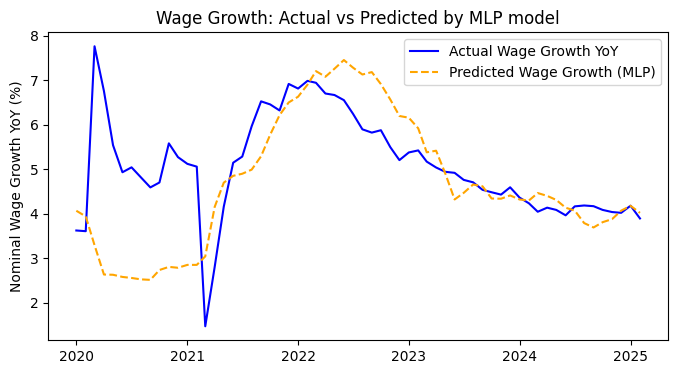

In [ ]:
# 🎯 Evaluate MLP on test set
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_true = y_test.flatten()

wage_pred_df = pd.DataFrame({
    'Date': data.index[split_idx:],
    'PredictedWageGrowth': y_pred,
    'ActualWageGrowth': y_true
}).set_index('Date')

# Plot actual vs predicted wage growth
plt.figure(figsize=(8,4))
plt.plot(wage_pred_df.index, wage_pred_df['ActualWageGrowth'], label='Actual Wage Growth YoY', color='blue')
plt.plot(wage_pred_df.index, wage_pred_df['PredictedWageGrowth'], label='Predicted Wage Growth (MLP)', color='orange', linestyle='--')
plt.title('Wage Growth: Actual vs Predicted by MLP model')
plt.ylabel('Nominal Wage Growth YoY (%)')
plt.legend()
plt.show()
